In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/STAT8021_QA_Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install accelerate -U

In [ ]:
import sys

import warnings
warnings.filterwarnings("ignore")

import os.path
import numpy as np
import pandas as pd
import re

from newsqa import NewsQaExample, NewsQaModel, create_dataset, get_single_prediction
import utils

from transformers import BertTokenizer, BertForQuestionAnswering, XLNetTokenizer
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering, XLNetForQuestionAnswering

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(2024)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef
from transformers import AutoModel, AutoTokenizer, AutoModelForQuestionAnswering
from sklearn.model_selection import train_test_split
import gc
import torch
import random
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator
import collections
import matplotlib.pyplot as plt

In [ ]:
# Loading the data
NEWS_STORIES = utils.open_pickle('data/news_stories.pkl')
data = pd.read_csv('data/newsqa-dataset-cleaned.csv')
total_examples = len(data)

In [ ]:
total_examples

87810

In [ ]:
data['story_text'] = data['story_id'].map(NEWS_STORIES)

In [ ]:
data = data.sample(50000)

In [ ]:
# Create an empty list to store the answers
answers = []

# Iterate over each row in the dataframe
for idx, row in data.iterrows():
    start_truth = row['start_idx']
    end_truth = row['end_idx']
    story_text = row['story_text']

    # Extract the answer
    answer = story_text[start_truth:end_truth]
    # Append the answer to the list
    answers.append(answer)


data['answer'] = answers

In [ ]:
# Create an empty list to store the combined values
combined_values = [[(row['start_idx'], row['end_idx'])] for idx, row in data.iterrows()]
data['start-end'] = combined_values

In [ ]:
data['narrowed_context'] = data['story_text']

In [ ]:
df_filtered = data[['question','narrowed_context','start-end','answer']]

In [ ]:
df_filtered.head(20)

,question,narrowed_context,start-end,answer
70272,what countries are involved,WASHINGTON (CNN) -- The United States is keepi...,"[(24, 37)]",United States
87006,where One body found earlier?,(CNN) -- Another body was found in the same 9...,"[(36, 92)]","the same 92-acre parcel west of Albuquerque, N..."
82719,When will BP try again to insert the tube?,"New Orleans, Louisiana (CNN) -- A mechanical p...","[(341, 360)]",Saturday night. The
24054,What is the name of the former Indian president?,"NEW DELHI, India (CNN) -- Indian authorities T...","[(214, 233)]",APJ Abdul Kalam was
56750,is marijuana allowed in argentina?,(CNN) -- A federal appeals court in Argentina ...,"[(153, 192)]",allows personal consumption of marijuan
56908,what does sale include?,"Beijing, China (CNN) -- China has threatened t...","[(1293, 1326)]",mine-hunting ships; and dozens of
38706,Who will appear as an extra?,"LOS ANGELES, California (CNN) -- Before Jada P...","[(-1, -1)]",
4720,when is the last tonight show taking place,"LOS ANGELES, California (CNN) -- Jay Leno plan...","[(294, 301)]",May 29.
45448,"What did the student tell News-Star of Monroe,...",(CNN) -- A student who videoed a re-enactment ...,"[(101, 146)]",was not intended to make fun of the six black
8617,What was Momeni arrested for?,WASHINGTON (CNN) -- Officials in the United St...,"[(376, 435)]",unlawfully passing another vehicle while drivi...


In [ ]:
cleaned_values = [[row['answer']] if (row['start-end'] != (-1, -1)) else [] for idx, row in df_filtered.iterrows()]

In [ ]:
df_filtered['answer'] = cleaned_values

In [ ]:
df_filtered

,question,narrowed_context,start-end,answer
70272,what countries are involved,WASHINGTON (CNN) -- The United States is keepi...,"[(24, 37)]",[United States]
87006,where One body found earlier?,(CNN) -- Another body was found in the same 9...,"[(36, 92)]","[the same 92-acre parcel west of Albuquerque, ..."
82719,When will BP try again to insert the tube?,"New Orleans, Louisiana (CNN) -- A mechanical p...","[(341, 360)]",[Saturday night. The]
24054,What is the name of the former Indian president?,"NEW DELHI, India (CNN) -- Indian authorities T...","[(214, 233)]",[APJ Abdul Kalam was]
56750,is marijuana allowed in argentina?,(CNN) -- A federal appeals court in Argentina ...,"[(153, 192)]",[allows personal consumption of marijuan]
...,...,...,...,...
83213,Where did the attack occur?,(CNN) -- A man who told Maryland State Police ...,"[(561, 592)]",[Jersey Turnpike while returning]
53440,Who is believed to possibly come out of retire...,(CNN) -- Ferrari president Luca di Montezemolo...,"[(115, 133)]",[Michael Schumacher]
11032,who were rigged?,(CNN) -- Moldova's president Wednesday accused...,"[(251, 274)]",[Moldova's election have]
27544,Who sent employees to buy drugs for company use?,NEW YORK (CNN) -- A new lawsuit alleges that ...,"[(65, 78)]",[Bernie Madoff]


In [ ]:
len(df_filtered["question"].value_counts())

48704

In [ ]:
X = df_filtered[['question', 'narrowed_context']]
y = df_filtered[["start-end", "answer"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

df_train = pd.concat([X_train, y_train], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
def tokenize_df(df, tokenizer, MAX_LEN, stride):

    return tokenizer(
        list(df['question']),
        list(df['narrowed_context']),
        max_length = MAX_LEN,
        return_overflowing_tokens = True,
        truncation = 'only_second',
        return_offsets_mapping = True,
        stride = stride,
        padding = 'max_length'
    )

In [ ]:
def preprocess_data(df, tokenizer, max_len, stride):
    start_positions = []
    end_positions = []

    tokenized = tokenize_df(df, tokenizer, max_len, stride)

    offsets_mapping = tokenized["offset_mapping"]
    for i, offset in enumerate(offsets_mapping):
        sequence_ids = tokenized.token_type_ids[i]

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 2

        df_index = tokenized["overflow_to_sample_mapping"][i]
        list_start_end = df.loc[df_index, "start-end"]
        if i == 774:
            print(list_start_end, context_start, context_end, df_index, offset[context_start][0], offset[context_end][1])

        for start_char, end_char in list_start_end:
            if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
                continue
            elif offset[context_start][0] > start_char:
                continue
            else:
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)
                if i == 2:
                    print(start_positions, end_positions)
                break

        if len(start_positions) == i:
            start_positions.append(0)
            end_positions.append(0)

        if i == 774:
            print(start_positions, end_positions)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

In [ ]:
MAX_LEN = 512
stride = 128

data_preprocessing_pipeline = lambda df: preprocess_data(df, tokenizer, MAX_LEN, stride)

df_train_tokenized = data_preprocessing_pipeline(df_train)
df_val_tokenized = data_preprocessing_pipeline(df_val)
df_test_tokenized = data_preprocessing_pipeline(df_test)

[(1914, 1940)] 31 509 308 0 2376
[22, 0, 0, 0, 39, 93, 0, 0, 0, 66, 0, 214, 0, 0, 0, 238, 0, 0, 0, 195, 389, 145, 0, 0, 0, 0, 231, 0, 396, 20, 0, 0, 30, 0, 219, 0, 0, 0, 27, 0, 89, 0, 0, 30, 0, 28, 0, 0, 51, 0, 33, 0, 446, 74, 0, 0, 87, 0, 0, 0, 0, 0, 185, 0, 0, 178, 265, 148, 185, 0, 0, 344, 0, 239, 0, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 203, 0, 47, 0, 0, 236, 0, 69, 0, 26, 0, 421, 51, 0, 0, 0, 449, 78, 0, 346, 0, 69, 0, 0, 163, 0, 326, 41, 0, 0, 0, 397, 22, 0, 0, 126, 0, 0, 155, 0, 0, 0, 198, 0, 0, 276, 0, 0, 0, 206, 0, 0, 109, 0, 210, 0, 104, 0, 0, 415, 302, 0, 54, 0, 0, 0, 88, 37, 0, 0, 0, 0, 501, 128, 0, 0, 185, 0, 0, 134, 0, 0, 56, 0, 344, 90, 0, 204, 0, 92, 0, 0, 0, 0, 0, 0, 0, 353, 264, 224, 372, 0, 0, 0, 41, 0, 271, 263, 135, 120, 0, 0, 0, 0, 102, 0, 16, 0, 0, 0, 0, 116, 309, 44, 271, 0, 0, 152, 0, 0, 0, 51, 0, 30, 0, 0, 427, 159, 174, 0, 194, 0, 0, 14, 0, 0, 0, 167, 0, 406, 369, 0, 348, 0, 70, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 38, 0, 137, 0, 0, 0, 0, 28, 0, 107, 0, 0, 314, 91, 0, 0,

In [ ]:
class TextDataset(Dataset):
    def __init__(self, questions, starts, ends, attention_masks, df_index, offset_mapping):
        self.questions = questions
        self.starts = starts
        self.ends = ends
        self.attention_masks = attention_masks
        self.df_index = df_index
        self.offset_mapping = offset_mapping

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = self.questions[item]
        attention_mask = self.attention_masks[item]
        start = self.starts[item]
        end = self.ends[item]
        df_index = self.df_index[item]
        offset_mapping = self.offset_mapping[item]


        return {
          'input_ids': torch.tensor(question, dtype = torch.long),
          'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
          'start_positions': torch.tensor(start, dtype=torch.long),
          'end_positions' : torch.tensor(end, dtype = torch.long),
          'df_index': torch.tensor(df_index, dtype=torch.long),
          'offset_mapping': offset_mapping
        }

In [ ]:
train_dataset = TextDataset(
    questions = df_train_tokenized['input_ids'],
    starts = df_train_tokenized['start_positions'],
    ends = df_train_tokenized['end_positions'],
    attention_masks = df_train_tokenized['attention_mask'],
    df_index = df_train_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_train_tokenized["offset_mapping"]
)

In [ ]:
val_dataset = TextDataset(
    questions = df_val_tokenized['input_ids'],
    starts = df_val_tokenized['start_positions'],
    ends = df_val_tokenized['end_positions'],
    attention_masks = df_val_tokenized['attention_mask'],
    df_index = df_val_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_val_tokenized["offset_mapping"]
)

In [ ]:
test_dataset = TextDataset(
    questions = df_test_tokenized['input_ids'],
    starts = df_test_tokenized['start_positions'],
    ends = df_test_tokenized['end_positions'],
    attention_masks = df_test_tokenized['attention_mask'],
    df_index = df_test_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_test_tokenized["offset_mapping"]
)

In [ ]:
batch_size = 8

In [ ]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda")

In [ ]:
from transformers import TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("xlnet-base-cased").to(device)
model_checkpoint = "xlnet-base-cased"

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir = "xlnet_7",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    logging_dir = "/logs/runs",
    do_train = True,
    do_eval = True,
    learning_rate=5e-5, # best 5e-5
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=6, # best 6
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps = 25

)

Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator


trainer = Trainer(
    model,
    args,
    train_dataset= train_dataset,
    eval_dataset= val_dataset,
    data_collator=data_collator
)

In [ ]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss
0,1.196900,1.175019
1,0.907300,1.164199
2,0.707100,1.269705


CPU times: user 13h 41min 8s, sys: 4h 22min 29s, total: 18h 3min 38s
Wall time: 17h 21min 14s


TrainOutput(global_step=6309, training_loss=1.0912137713290977, metrics={'train_runtime': 62471.1979, 'train_samples_per_second': 4.848, 'train_steps_per_second': 0.101, 'total_flos': 8.571804034461696e+16, 'train_loss': 1.0912137713290977, 'epoch': 2.9995245641838353})

In [ ]:
# current best "/content/drive/MyDrive/SEW.NLP/logs/xlnet_6/checkpoint-262"

#PATH_MODEL = "/content/drive/MyDrive/STAT8021_QA_Project/xlnet_7/checkpoint-4206" # path of model saved at best epoch
#Base line (Pre-train)
PATH_MODEL = "xlnet-base-cased" # path of model saved at best epoch
best_model = AutoModelForQuestionAnswering.from_pretrained(PATH_MODEL)

Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

val_predictions = best_trainer.predict(val_dataset)

In [ ]:
df_train_tokenized[0].tokens

['▁Which',
 '▁president',
 '▁was',
 '▁mock',
 'ed',
 '?',
 '<sep>',
 '▁',
 '(',
 'CN',
 'N',
 ')',
 '▁',
 '-',
 '-',
 '▁Chevy',
 '▁Chase',
 '▁didn',
 "'",
 't',
 '▁look',
 '▁like',
 '▁Gerald',
 '▁Ford',
 '▁and',
 '▁didn',
 "'",
 't',
 '▁sound',
 '▁like',
 '▁Gerald',
 '▁Ford',
 '.',
 '▁But',
 '▁in',
 '▁the',
 '▁mid',
 '-',
 '1970',
 's',
 ',',
 '▁when',
 '▁',
 '"',
 'Saturday',
 '▁Night',
 '▁Live',
 '"',
 '▁first',
 '▁went',
 '▁on',
 '▁the',
 '▁air',
 ',',
 '▁Chase',
 '▁',
 '-',
 '-',
 '▁then',
 '▁a',
 '▁writer',
 '▁and',
 '▁cast',
 '▁member',
 '▁of',
 '▁the',
 '▁show',
 '▁',
 '-',
 '-',
 '▁made',
 '▁his',
 '▁impression',
 '▁of',
 '▁the',
 '▁president',
 ',',
 '▁rife',
 '▁with',
 '▁',
 'pra',
 't',
 'fall',
 's',
 '▁and',
 '▁slap',
 'stick',
 ',',
 '▁the',
 '▁talk',
 '▁of',
 '▁the',
 '▁country',
 '.',
 '▁He',
 '▁also',
 '▁made',
 '▁the',
 '▁president',
 '▁a',
 '▁but',
 't',
 '▁of',
 '▁jokes',
 ',',
 '▁which',
 '▁was',
 '▁intentional',
 ',',
 '▁Chase',
 '▁told',
 '▁CNN',
 '▁in',
 '▁an',


In [ ]:
def compute_best_prediction(start_indexes, end_indexes,
                            start_logits, end_logits,
                            sequence_ids, offset_mapping, context):
    """
      Computes best feasible prediction and compares it with null prediction
    """


    best_score, null_score = -np.inf, -np.inf
    best_answer = ""
    best_start, best_end = 0, 0


    for start_index in start_indexes:
        for end_index in end_indexes:
            score = start_logits[start_index] + end_logits[end_index]
            if start_index == 0 or end_index == 0: # null prediction
                if start_index != end_index:
                    continue
                null_score = score

            elif start_index <= end_index and sequence_ids[start_index] == 1 and sequence_ids[end_index] == 1 and start_index != 510 and end_index != 510:
                if score > best_score:
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    if end_char > 0:
                        best_answer = context[start_char:end_char]
                        best_score = score
                        best_start = start_index
                        best_end = end_index

    score_diff = null_score - best_score


    return {
        "score_diff": score_diff,
        "pred_start": best_start,
        "pred_end": best_end,
        "pred_answer": best_answer
    }

In [ ]:
def get_preds_df(predictions, df, tokenized_df, dataset):
    predicted_answers = []
    n_best_size = 20

    test_start_logits, test_end_logits = predictions.predictions
    start_labels, end_labels = tokenized_df["start_positions"], tokenized_df["end_positions"]

    for i in range(len(dataset)):

        start_label, end_label = start_labels[i], end_labels[i]
        start_logits, end_logits = test_start_logits[i], test_end_logits[i]

        start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
        end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

        row_idx = dataset[i]["df_index"].item()
        row_context = df.loc[row_idx, "narrowed_context"]
        offset_mapping = dataset[i]["offset_mapping"]
        sequence_ids = tokenized_df.token_type_ids[i]

        # find predicted answer:
        prediction = compute_best_prediction(start_indexes, end_indexes, start_logits, end_logits, sequence_ids, offset_mapping, row_context)

        # find correct answer:
        start_char_true = offset_mapping[start_label][0]
        end_char_true = offset_mapping[end_label][1]
        correct_answer = row_context[start_char_true:end_char_true+1] if end_label > 0 else ""

        prediction["pred_token"] = tokenized_df[i].tokens[prediction["pred_start"]:prediction["pred_end"]+1]
        prediction["start_label"] = start_label
        prediction["end_label"] = end_label
        prediction["correct_answer"] = correct_answer
        prediction["correct_token"] = tokenized_df[i].tokens[start_label:end_label+1] if end_label > 0 else [""]

        predicted_answers.append(prediction)

    preds_df = pd.DataFrame(predicted_answers)
    preds_df["NoAnsw"] = preds_df.apply(lambda row: row["correct_token"] == [""], axis=1)

    return preds_df

In [ ]:
val_preds_df = get_preds_df(val_predictions, df_val, df_val_tokenized, val_dataset)

In [ ]:
val_preds_df[val_preds_df["correct_answer"] != ""].tail(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
12363,-inf,12,95,CNN) -- President Obama's address to Congress ...,"[CN, N, ), ▁, -, -, ▁President, ▁Obama, ', s, ...",49,55,the end of his first term.\n,"[▁the, ▁end, ▁of, ▁his, ▁first, ▁term, .]",False
12369,-inf,79,320,"of southeast Asian nations in Phuket, Thailand...","[▁of, ▁southeast, ▁Asian, ▁nations, ▁in, ▁Phuk...",39,40,"Clinton,","[▁Clinton, ,]",False
12371,-inf,128,212,their tickets and have a wristband placed on t...,"[▁their, ▁tickets, ▁and, ▁have, ▁a, ▁wrist, ba...",48,48,two,[▁two],False
12374,-inf,9,260,CNN) -- The relatives of a woman who died on t...,"[CN, N, ), ▁, -, -, ▁The, ▁relatives, ▁of, ▁a,...",86,89,"hospital workers, who","[▁hospital, ▁workers, ,, ▁who]",False
12376,-inf,323,499,the conversation about 1.4 million disappointm...,"[▁the, ▁conversation, ▁about, ▁1, ., 4, ▁milli...",61,84,the country looks at itself differently. And d...,"[▁the, ▁country, ▁looks, ▁at, ▁itself, ▁differ...",False
12378,-inf,144,193,a country that lacks sufficient medical servic...,"[▁a, ▁country, ▁that, ▁lacks, ▁sufficient, ▁me...",421,425,physical custody of a child,"[▁physical, ▁custody, ▁of, ▁a, ▁child]",False
12379,-inf,426,452,", France and Canada.\n\nOne of those cases is ...","[,, ▁France, ▁and, ▁Canada, ., ▁One, ▁of, ▁tho...",53,57,physical custody of a child,"[▁physical, ▁custody, ▁of, ▁a, ▁child]",False
12382,-inf,75,101,"a hotel surveillance video.\n\n""When I saw her...","[▁a, ▁hotel, ▁surveillance, ▁video, ., ▁, "", W...",70,73,was her daughter seen,"[▁was, ▁her, ▁daughter, ▁seen]",False
12384,-inf,220,269,"in the immediate aftermath.\n\nAbout 20,000 U....","[▁in, ▁the, ▁immediate, ▁aftermath, ., ▁About,...",28,28,A,[▁A],False
12385,-inf,304,319,"from Downing Street, said the new president wa...","[▁from, ▁Down, ing, ▁Street, ,, ▁said, ▁the, ▁...",310,324,"the new president was a ""man of great vision a...","[▁the, ▁new, ▁president, ▁was, ▁a, ▁, "", man, ...",False


In [ ]:
import collections

def compute_accuracy(gold_toks, pred_toks):
    num_correct = sum(1 for gold, pred in zip(gold_toks, pred_toks) if gold == pred)
    accuracy = num_correct / len(gold_toks)
    return accuracy

def compute_f1(gold_toks, pred_toks):
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks), compute_accuracy(gold_toks, pred_toks)
    if num_same == 0:
        return 0, compute_accuracy(gold_toks, pred_toks)
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, compute_accuracy(gold_toks, pred_toks)

In [ ]:
def get_f1_df(preds_df):
    f1_data = {"threshold": [], "f1":[], "f1_Answ":[], "f1_NoAnsw":[],"accuracy":[],"accuracy_Answ":[],"accuracy_NoAnsw":[]}
    #f1_data = {"threshold": [], "f1":[]}
    for threshold in np.arange(-3, 10, 1):
        temp = preds_df.copy()
        temp["pred_token"] = temp.apply(lambda row: row["pred_token"] if row["score_diff"] < threshold else [""], axis=1)
        temp["f1"], temp["accuracy"] = zip(*temp.apply(lambda r: compute_f1(r["correct_token"], r["pred_token"]), axis=1))
        temp["f1"] = temp['f1'].astype(float)
        f1_total = 100 * np.mean(temp["f1"])
        f1_scores = list(100 * temp.groupby("NoAnsw")["f1"].mean())
        accuracy_total = 100 * np.mean(temp["accuracy"])
        accuracy = list(100 * temp.groupby("NoAnsw")["accuracy"].mean())

        f1_data["threshold"].append(threshold)
        f1_data["f1"].append(f1_total)
        f1_data["f1_Answ"].append(f1_scores[0])
        f1_data["f1_NoAnsw"].append(f1_scores[1])
        f1_data["accuracy"].append(accuracy_total)
        f1_data["accuracy_Answ"].append(accuracy[0])
        f1_data["accuracy_NoAnsw"].append(accuracy[1])
    df_scores = pd.DataFrame(f1_data)

    return df_scores
val_scores = get_f1_df(val_preds_df)

In [ ]:
val_scores

,threshold,f1,f1_Answ,f1_NoAnsw,accuracy,accuracy_Answ,accuracy_NoAnsw
0,-3,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
1,-2,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
2,-1,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
3,0,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
4,1,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
5,2,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
6,3,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
7,4,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
8,5,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448
9,6,2.598057,5.447696,0.915448,0.952535,1.015343,0.915448


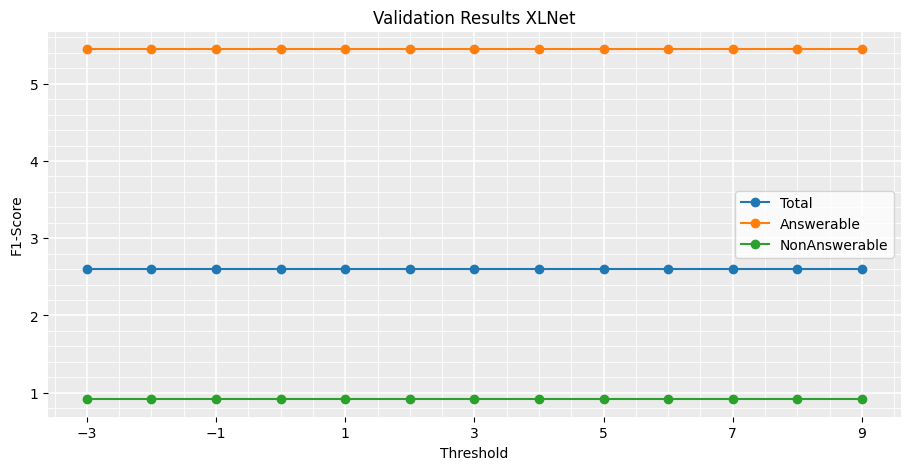

In [ ]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
ax.title.set_text("Validation Results XLNet")

ax.set_facecolor('#EBEBEB')
# Remove border around plot.
[ax.spines[side].set_visible(False) for side in ax.spines]
# Style the grid.
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)
# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which='minor', bottom=False, left=False)


ax.plot(val_scores["threshold"], val_scores["f1"], "-o", label="Total")
ax.plot(val_scores["threshold"], val_scores["f1_Answ"], "-o", label="Answerable")
ax.plot(val_scores["threshold"], val_scores["f1_NoAnsw"], "-o", label="NonAnswerable")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1-Score")
ax.set_xticks(np.array(val_scores["threshold"])[::2])
ax.legend()
plt.show()

In [ ]:

## Pick a threshold with decent f1 and good f1_Answ, like 3 or 4
threshold = 3

In [ ]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

test_predictions = best_trainer.predict(test_dataset)

In [ ]:
test_preds_df = get_preds_df(test_predictions, df_test, df_test_tokenized, test_dataset)

In [ ]:
test_preds_df[test_preds_df["correct_answer"] != ""].head(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
4,-inf,480,497,"in northwestern Pakistan kills at least three,...","[▁in, ▁northwestern, ▁Pakistan, ▁kills, ▁at, ▁...",83,84,three men,"[▁three, ▁men]",False
6,-inf,288,444,of the treatment of journalists with the Egypt...,"[▁of, ▁the, ▁treatment, ▁of, ▁journalists, ▁wi...",311,319,"Sameh Shoukry, Egypt's","[▁Sam, eh, ▁Shou, k, ry, ,, ▁Egypt, ', s]",False
9,-inf,145,447,"any responsibility for the attacks, but a susp...","[▁any, ▁responsibility, ▁for, ▁the, ▁attacks, ...",237,246,is obligated to root out terrorists within its...,"[▁is, ▁obligated, ▁to, ▁root, ▁out, ▁terrorist...",False
10,-inf,263,266,the nation are excellent,"[▁the, ▁nation, ▁are, ▁excellent]",366,369,online system Monday at,"[▁online, ▁system, ▁Monday, ▁at]",False
16,-inf,281,331,", including Senate Majority Leader Harry Reid,...","[,, ▁including, ▁Senate, ▁Majority, ▁Leader, ▁...",55,60,U.S. Capitol.\n,"[▁U, ., S, ., ▁Capitol, .]",False
19,-inf,136,285,to the Centers for Disease Control and Prevent...,"[▁to, ▁the, ▁Center, s, ▁for, ▁Disease, ▁Contr...",33,46,they found the bacteria on a jalapeño pepper i...,"[▁they, ▁found, ▁the, ▁bacteria, ▁on, ▁a, ▁, j...",False
21,-inf,282,294,the villain in the next James Bond installment...,"[▁the, ▁villain, ▁in, ▁the, ▁next, ▁James, ▁Bo...",359,390,very excited. My parents took me to watch the ...,"[▁very, ▁excited, ., ▁My, ▁parents, ▁took, ▁me...",False
22,-inf,406,464,A spokesman for the UK Foreign and Commonwealt...,"[▁A, ▁spokesman, ▁for, ▁the, ▁UK, ▁Foreign, ▁a...",69,72,"October 23, just","[▁October, ▁23, ,, ▁just]",False
24,-inf,270,320,the U.S. command in Iraq reported.\n\nHe was t...,"[▁the, ▁U, ., S, ., ▁command, ▁in, ▁Iraq, ▁rep...",240,242,"Tariq Aziz,","[▁Tariq, ▁Aziz, ,]",False
25,-inf,152,422,other leaders from the Western Hemisphere in T...,"[▁other, ▁leaders, ▁from, ▁the, ▁Western, ▁Hem...",19,21,$410 billion,"[▁$4, 10, ▁billion]",False


In [ ]:
df_test[:50]

,question,narrowed_context,start-end,answer
0,what is more than 50 percent faster than the o...,"(CNN) -- Another summer, another iPhone hardwa...","[(-1, -1)]",[]
1,What was the number of men involved?,"ISLAMABAD, Pakistan (CNN) -- Pakistani forces...","[(354, 363)]",[three men]
2,What did the U.S government say?,"Cairo, Egypt (CNN) -- As some opposition group...","[(1455, 1477)]","[Sameh Shoukry, Egypt's]"
3,What did Rice say about Pakistan's obligations?,"WASHINGTON (CNN) -- ""There's no doubt"" that th...","[(2331, 2386)]",[is obligated to root out terrorists within it...
4,What did NAACP unveil?,NEW YORK (CNN) -- Fight police misconduct wit...,"[(904, 927)]",[online system Monday at]
5,What will the defense do?,"LOS ANGELES, California (CNN) -- After about ...","[(-1, -1)]",[]
6,What election is this referring to?,"(CNN Student News) -- Each month in 2008, CN...","[(-1, -1)]",[]
7,Where will the bust be on display?,"(CNN) -- After a nearly decade-long effort, th...","[(194, 207)]",[U.S. Capitol.]
8,What discovery was termed a significant break?,"WASHINGTON (CNN) -- Investigators had a ""signi...","[(101, 166)]",[they found the bacteria on a jalapeño pepper ...
9,What did they say?,(EW.com) -- After months of speculation about ...,"[(397, 521)]",[very excited. My parents took me to watch the...


In [ ]:
test_scores = get_f1_df(test_preds_df)

In [ ]:
test_scores

,threshold,f1,f1_Answ,f1_NoAnsw,accuracy,accuracy_Answ,accuracy_NoAnsw
0,-3,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
1,-2,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
2,-1,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
3,0,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
4,1,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
5,2,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
6,3,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
7,4,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
8,5,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378
9,6,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378


In [ ]:
test_scores[test_scores["threshold"] == threshold] # final score

,threshold,f1,f1_Answ,f1_NoAnsw,accuracy,accuracy_Answ,accuracy_NoAnsw
6,3,2.557293,5.590802,0.864378,0.93187,1.052808,0.864378


In [ ]:
# current best "/content/drive/MyDrive/SEW.NLP/logs/xlnet_6/checkpoint-262"

PATH_MODEL = "/content/drive/MyDrive/STAT8021_QA_Project/xlnet_7/checkpoint-4206" # path of model saved at best epoch
#Base line (Pre-train)
#PATH_MODEL = "xlnet-base-cased" # path of model saved at best epoch
best_model = AutoModelForQuestionAnswering.from_pretrained(PATH_MODEL)

In [ ]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

val_predictions = best_trainer.predict(val_dataset)

In [ ]:
val_preds_df = get_preds_df(val_predictions, df_val, df_val_tokenized, val_dataset)

In [ ]:
val_preds_df[val_preds_df["correct_answer"] != ""].tail(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
12363,-3.883308,48,55,by the end of his first term.,"[▁by, ▁the, ▁end, ▁of, ▁his, ▁first, ▁term, .]",49,55,the end of his first term.\n,"[▁the, ▁end, ▁of, ▁his, ▁first, ▁term, .]",False
12369,-10.818742,31,40,"U.S. Secretary of State Hillary Clinton,","[▁U, ., S, ., ▁Secretary, ▁of, ▁State, ▁Hillar...",39,40,"Clinton,","[▁Clinton, ,]",False
12371,-4.345927,48,48,two,[▁two],48,48,two,[▁two],False
12374,-8.007511,86,90,"hospital workers, who they","[▁hospital, ▁workers, ,, ▁who, ▁they]",86,89,"hospital workers, who","[▁hospital, ▁workers, ,, ▁who]",False
12376,-6.868688,61,67,the country looks at itself differently.,"[▁the, ▁country, ▁looks, ▁at, ▁itself, ▁differ...",61,84,the country looks at itself differently. And d...,"[▁the, ▁country, ▁looks, ▁at, ▁itself, ▁differ...",False
12378,-1.698658,378,380,parent gets custody,"[▁parent, ▁gets, ▁custody]",421,425,physical custody of a child,"[▁physical, ▁custody, ▁of, ▁a, ▁child]",False
12379,-0.104827,53,58,physical custody of a child retains,"[▁physical, ▁custody, ▁of, ▁a, ▁child, ▁retains]",53,57,physical custody of a child,"[▁physical, ▁custody, ▁of, ▁a, ▁child]",False
12382,-4.840145,71,73,her daughter seen,"[▁her, ▁daughter, ▁seen]",70,73,was her daughter seen,"[▁was, ▁her, ▁daughter, ▁seen]",False
12384,-7.390514,29,30,tsunami advisory,"[▁tsunami, ▁advisory]",28,28,A,[▁A],False
12385,-2.742652,71,115,"""I believe President Obama will exercise outst...","["", I, ▁believe, ▁President, ▁Obama, ▁will, ▁e...",310,324,"the new president was a ""man of great vision a...","[▁the, ▁new, ▁president, ▁was, ▁a, ▁, "", man, ...",False


In [ ]:
val_scores = get_f1_df(val_preds_df)

In [ ]:
val_scores

,threshold,f1,f1_Answ,f1_NoAnsw,accuracy,accuracy_Answ,accuracy_NoAnsw
0,-3,79.835934,48.787187,98.169104,75.160785,36.194286,98.169104
1,-2,80.643202,52.296688,97.380801,75.459674,38.334423,97.380801
2,-1,80.986322,54.577499,96.579784,75.390206,39.503894,96.579784
3,0,80.896135,56.186425,95.486332,75.035704,40.400866,95.486332
4,1,80.244039,57.379992,93.744437,74.169840,41.018632,93.744437
5,2,79.565786,58.373905,92.078830,73.354113,41.642249,92.078830
6,3,78.567676,59.066120,90.082645,72.233718,42.005078,90.082645
7,4,77.231359,59.536406,87.679593,70.786739,42.177286,87.679593
8,5,75.830014,59.917667,85.225683,69.297221,42.321045,85.225683
9,6,73.954598,60.206301,82.072473,67.382913,42.504921,82.072473


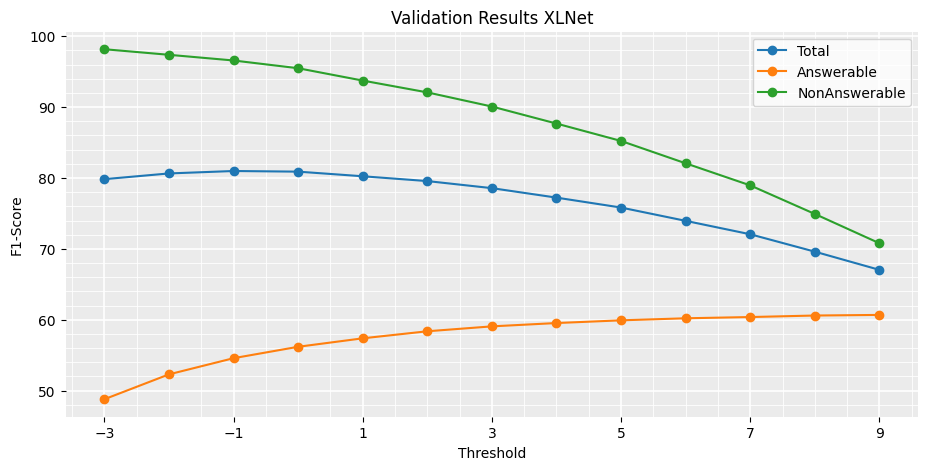

In [ ]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
ax.title.set_text("Validation Results XLNet")

ax.set_facecolor('#EBEBEB')
# Remove border around plot.
[ax.spines[side].set_visible(False) for side in ax.spines]
# Style the grid.
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)
# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which='minor', bottom=False, left=False)


ax.plot(val_scores["threshold"], val_scores["f1"], "-o", label="Total")
ax.plot(val_scores["threshold"], val_scores["f1_Answ"], "-o", label="Answerable")
ax.plot(val_scores["threshold"], val_scores["f1_NoAnsw"], "-o", label="NonAnswerable")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1-Score")
ax.set_xticks(np.array(val_scores["threshold"])[::2])
ax.legend()
plt.show()

In [ ]:

## Pick a threshold with decent f1 and good f1_Answ, like 3 or 4
threshold = 3

In [ ]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

test_predictions = best_trainer.predict(test_dataset)

In [ ]:
test_preds_df = get_preds_df(test_predictions, df_test, df_test_tokenized, test_dataset)

In [ ]:
test_preds_df[test_preds_df["correct_answer"] == ""].head(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
0,-1.505561,356,356,recording,[▁recording],0,0,,[],True
1,7.203023,89,111,integrated some kind of anti-shake feature int...,"[▁integrated, ▁some, ▁kind, ▁of, ▁anti, -, sha...",0,0,,[],True
2,13.843695,20,20,more,[▁more],0,0,,[],True
3,19.950878,224,231,revision is in the iPhone's future,"[▁revision, ▁is, ▁in, ▁the, ▁iPhone, ', s, ▁fu...",0,0,,[],True
5,23.709641,352,359,"continue targeted actions against the Taliban.""","[▁continue, ▁targeted, ▁actions, ▁against, ▁th...",0,0,,[],True
7,-0.856759,419,436,Interior Ministry was behind the journalist de...,"[▁Interior, ▁Ministry, ▁was, ▁behind, ▁the, ▁j...",0,0,,[],True
8,-0.610174,193,212,"responsibility to act, and it doesn't matter t...","[▁responsibility, ▁to, ▁act, ,, ▁and, ▁it, ▁do...",0,0,,[],True
11,-0.277021,178,179,appeal.,"[▁appeal, .]",0,0,,[],True
12,15.648804,449,452,manslaughter against Spector.,"[▁manslaughter, ▁against, ▁Spector, .]",0,0,,[],True
13,19.306438,126,194,claimed he had threatened them with firearms. ...,"[▁claimed, ▁he, ▁had, ▁threatened, ▁them, ▁wit...",0,0,,[],True


In [ ]:
test_preds_df[test_preds_df["correct_answer"] == ""].head(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
0,-1.505561,356,356,recording,[▁recording],0,0,,[],True
1,7.203023,89,111,integrated some kind of anti-shake feature int...,"[▁integrated, ▁some, ▁kind, ▁of, ▁anti, -, sha...",0,0,,[],True
2,13.843695,20,20,more,[▁more],0,0,,[],True
3,19.950878,224,231,revision is in the iPhone's future,"[▁revision, ▁is, ▁in, ▁the, ▁iPhone, ', s, ▁fu...",0,0,,[],True
5,23.709641,352,359,"continue targeted actions against the Taliban.""","[▁continue, ▁targeted, ▁actions, ▁against, ▁th...",0,0,,[],True
7,-0.856759,419,436,Interior Ministry was behind the journalist de...,"[▁Interior, ▁Ministry, ▁was, ▁behind, ▁the, ▁j...",0,0,,[],True
8,-0.610174,193,212,"responsibility to act, and it doesn't matter t...","[▁responsibility, ▁to, ▁act, ,, ▁and, ▁it, ▁do...",0,0,,[],True
11,-0.277021,178,179,appeal.,"[▁appeal, .]",0,0,,[],True
12,15.648804,449,452,manslaughter against Spector.,"[▁manslaughter, ▁against, ▁Spector, .]",0,0,,[],True
13,19.306438,126,194,claimed he had threatened them with firearms. ...,"[▁claimed, ▁he, ▁had, ▁threatened, ▁them, ▁wit...",0,0,,[],True


In [ ]:
df_test[:50]

,question,narrowed_context,start-end,answer
0,what is more than 50 percent faster than the o...,"(CNN) -- Another summer, another iPhone hardwa...","[(-1, -1)]",[]
1,What was the number of men involved?,"ISLAMABAD, Pakistan (CNN) -- Pakistani forces...","[(354, 363)]",[three men]
2,What did the U.S government say?,"Cairo, Egypt (CNN) -- As some opposition group...","[(1455, 1477)]","[Sameh Shoukry, Egypt's]"
3,What did Rice say about Pakistan's obligations?,"WASHINGTON (CNN) -- ""There's no doubt"" that th...","[(2331, 2386)]",[is obligated to root out terrorists within it...
4,What did NAACP unveil?,NEW YORK (CNN) -- Fight police misconduct wit...,"[(904, 927)]",[online system Monday at]
5,What will the defense do?,"LOS ANGELES, California (CNN) -- After about ...","[(-1, -1)]",[]
6,What election is this referring to?,"(CNN Student News) -- Each month in 2008, CN...","[(-1, -1)]",[]
7,Where will the bust be on display?,"(CNN) -- After a nearly decade-long effort, th...","[(194, 207)]",[U.S. Capitol.]
8,What discovery was termed a significant break?,"WASHINGTON (CNN) -- Investigators had a ""signi...","[(101, 166)]",[they found the bacteria on a jalapeño pepper ...
9,What did they say?,(EW.com) -- After months of speculation about ...,"[(397, 521)]",[very excited. My parents took me to watch the...


In [ ]:
test_scores = get_f1_df(test_preds_df)

In [ ]:
test_scores

,threshold,f1,f1_Answ,f1_NoAnsw,accuracy,accuracy_Answ,accuracy_NoAnsw
0,-3,80.725029,49.785977,97.991234,76.364480,37.611826,97.991234
1,-2,81.567516,53.403376,97.285123,76.682426,39.764767,97.285123
2,-1,81.797659,55.900182,96.250304,76.539361,41.219621,96.250304
3,0,81.660479,57.611433,95.081568,76.128470,42.166701,95.081568
4,1,81.140749,58.974544,93.511079,75.371855,42.868457,93.511079
5,2,80.459036,59.907229,91.928415,74.495528,43.257801,91.928415
6,3,79.261386,60.424785,89.773557,73.181397,43.450158,89.773557
7,4,78.202915,60.894612,87.862187,72.037858,43.682484,87.862187
8,5,76.783153,61.250172,85.451668,70.555975,43.864608,85.451668
9,6,74.931381,61.424916,82.468955,68.667845,43.937844,82.468955


In [ ]:
df_filtered.to_csv('data/df_filtered.csv')

In [ ]:
from transformers import pipeline
qa_model = AutoModelForQuestionAnswering.from_pretrained("/content/drive/MyDrive/STAT8021_QA_Project/xlnet_7/checkpoint-4206")
qa_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
qa_model.to(device)
#article_classifier_model.load_state_dict(torch.load('finetuned_BERT_epoch_4.model', map_location=torch.device('cpu')))
qa_system = pipeline(task='question-answering', model=qa_model, tokenizer=qa_tokenizer, device=torch.cuda.current_device())

In [ ]:
question = "In what city is the carnival?"
context = "(CNN) -- Dancers have put on a dazzling display atop extravagant floats at the legendary annual Rio Carnival. Thousands of revelers cheered as dancers shimmied and shook their colorful costumes through the streets of the Brazilian city. Seven-year-old Julia Lira took her place as the drum corps queen for the Viradouro School of Samba despite criticism that she was too young to fill a role normally reserved for voluptuous adult dancers. @highlight Parade of color during annual Rio Carnival in Brazil @highlight Dancers included seven-year-old Julia Lira, despite criticism that she was too young"
result = qa_system(question=question, context=context)

In [ ]:
print(result['answer'])

Rio Carnival.


In [ ]:
question = "What age is the dancer?"
context = "(CNN) -- Dancers have put on a dazzling display atop extravagant floats at the legendary annual Rio Carnival. Thousands of revelers cheered as dancers shimmied and shook their colorful costumes through the streets of the Brazilian city. Seven-year-old Julia Lira took her place as the drum corps queen for the Viradouro School of Samba despite criticism that she was too young to fill a role normally reserved for voluptuous adult dancers. @highlight Parade of color during annual Rio Carnival in Brazil @highlight Dancers included seven-year-old Julia Lira, despite criticism that she was too young"
result = qa_system(question=question, context=context)
print(result['answer'])

Seven-year-old Julia Lira took
